# 2024-03-20: NMF implementation using `Singlet` for single cell analysis
### By [Aishwarya Chander](aishwarya.chander@alleninstitute.org), High Resolution Translational Immunology/Computational Biology, Allen Institute for Immunology

**Main aim**: Use the R package `Singlet` to decompose a single cell data matrix into NMF matrices. 

### Primer: 

- Non-negative matrix factorization (NMF) is a matrix decomposition method, where we constrain the matrices to be non-negative. This technique splits a matrix V into two smaller matrices W and H non-negative matrices whose product is approximately equal to the original matrix.

- In a deep sense, we are actually compressing our data through a rank factorization. We want to reduce the original dimensions of our matrix of observations V of size N×M by decomposing it into two matrices W and H of size N×R and R×M. Since W × H only approximates V, this is actually lossy compression.

- Each column in W is a basis element, which means some component that shows up again and again in all of the original M data points. These components are the fundamental building blocks we can use to reconstruct an approximation to all the observed data points. On the other hand, each column in H is a set of mixture coefficients: they are like the weights of the building blocks in W for each data point in V. H shows us how to take a linear combination of the building blocks in W to approximate V.

- In yet other words, we can interpret V to be a weighted sum of some components, where each column in W is a component, and each column in H contains the weights of each component. Therefore, we can think of NMF as descompossing each data point into an overlay of certain components.

- Why do we want to do this? The idea is that there is some rule-driven process generating our data; we have taken a number of noisy measurements of the system's output, and we would like to discover the underlying structure of our data -- and ultimately infer the specific rules of the generative model.

- NMF can do almost anything that PCA can do, but also imputes missing signal, always has an optimal rank (for variance-stabilized data), uses all the information in your assay (incl. "non-variable" genes), is robust across experiments, learns signatures of transcriptional activity, and is colinear and non-negative (interpretable) rather than orthogonal and signed (not interpretable)

[`Singlet`](https://github.com/zdebruine/singlet) internally provides the fastest implementation of NMF. Cross-validation can take a few minutes for datasets with a few ten thousand cells, but is extremely scalable and runs excellently on HPC nodes and average laptops alike.

The original tutorial for this notebook can be found [here](https://zdebruine.github.io/singlet/articles/Guided_Clustering_with_NMF.html).

In [21]:
X

array([[0.61626303, 0.89715163, 0.98573459, ..., 0.43344779, 0.80590491,
        0.40137979],
       [0.98872905, 0.56759314, 0.46960511, ..., 0.32749388, 0.93519618,
        0.72330371],
       [0.16373282, 0.29160155, 0.10698038, ..., 0.21996147, 0.60477706,
        0.99681089],
       ...,
       [0.60226867, 0.22219596, 0.79913416, ..., 0.8844503 , 0.28584602,
        0.89513928],
       [0.74519928, 0.63364479, 0.35648999, ..., 0.83071311, 0.67234331,
        0.34042574],
       [0.55246296, 0.22010961, 0.30878933, ..., 0.76657711, 0.30949266,
        0.77494763]])

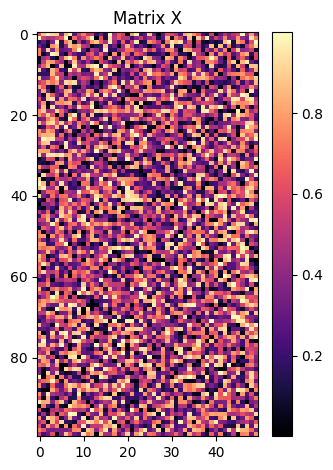

In [22]:
plt.subplot(1, 2, 2)
plt.imshow(X, cmap='magma', aspect='auto')
plt.title('Matrix X')
plt.colorbar()

plt.tight_layout()
plt.show()

In [32]:
# Specify the number of components for factorization
n_components = 25

# Perform NMF
model = NMF(n_components=n_components)
W = model.fit_transform(X)
H = model.components_

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


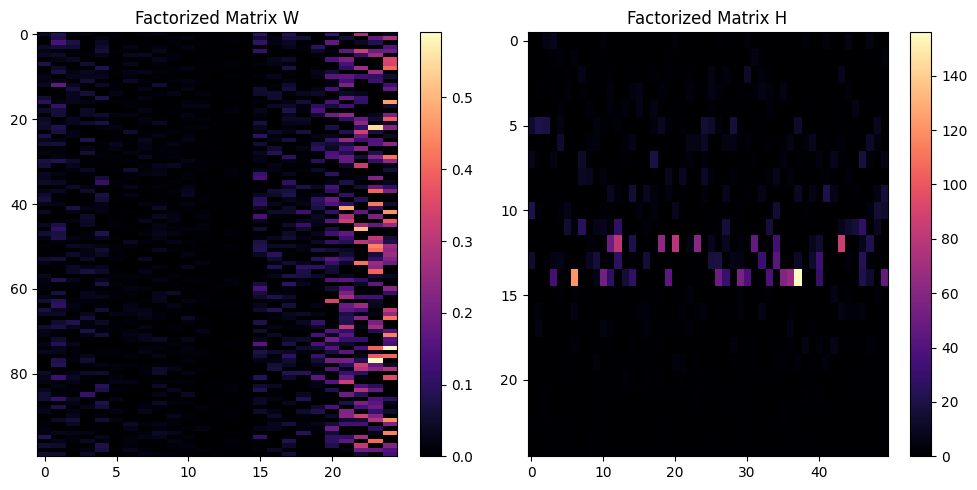

In [33]:
# Visualize the factorized matrices as heatmaps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(W, cmap='magma', aspect='auto')
plt.title('Factorized Matrix W')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(H, cmap='magma', aspect='auto')
plt.title('Factorized Matrix H')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# Specify the number of components for factorization
n_components = 10

# Perform NMF
model = NMF(n_components=n_components)
W = model.fit_transform(X)
H = model.components_

In [ ]:
# Visualize the factorized matrices as heatmaps
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(W, cmap='magma', aspect='auto')
plt.title('Factorized Matrix W')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(H, cmap='magma', aspect='auto')
plt.title('Factorized Matrix H')
plt.colorbar()

plt.tight_layout()
plt.show()

In [34]:
X_2 = np.matmul(W,H)

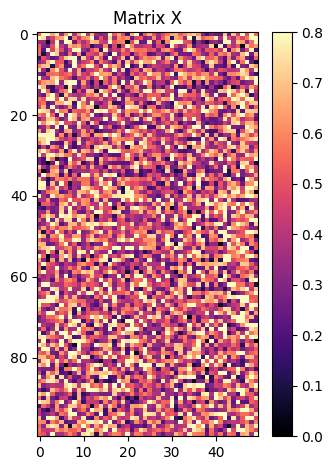

In [35]:
plt.subplot(1, 2, 2)
plt.imshow(X_2, cmap='magma', aspect='auto', vmin=0, vmax=0.8)
plt.title('Matrix X')
plt.colorbar()

plt.tight_layout()
plt.show()

In [1]:
## Install these packages before running Singlet -- Takes about 1-1.5hr to install some dependancies
# devtools::install_github("zdebruine/RcppML")
# BiocManager::install("fgsea")
# BiocManager::install("limma")
# devtools::install_github("zdebruine/singlet")

# load libraries
quiet_library <- function(...) {
    suppressMessages(library(...))
}

quiet_library(dplyr)
quiet_library(stringr)
quiet_library(ggplot2)
quiet_library(patchwork)
quiet_library(singlet)
quiet_library(Seurat)
options(Seurat.object.assay.version = "v5")

# Group.by UMAP wrapper function
gb_umap <- function(rdata, feature, reduction) {
  ## figure params
  options(repr.plot.width = 10, repr.plot.height = 10)
  
  ## generate UMAP with no warnings
  suppressMessages(
    suppressWarnings(
      DimPlot(rdata, reduction = reduction, group.by = feature,
          label=TRUE, repel = TRUE, shuffle=TRUE, label.size = 4, pt.size=1) + NoLegend()))
}

### Load in your files
> Here, I'm using some bone marrow progenitor cells from 4 health human donors. The bone marrow is an especially good use-case for NMF as it has noisy underlying signals and is hard to deconvolute into clusters. 

In [2]:
file_name = "../data_atlas_project/data_release/2024-02-01-bmmc_progs.rds"
rdata <- readRDS(file=file_name)

In [3]:
rdata

An object of class Seurat 
18232 features across 137153 samples within 2 assays 
Active assay: ADT (150 features, 150 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 7 dimensional reductions calculated: pca, apca, wnn.umap, rna.umap, adt.umap, harmony_rna, harmony_adt

> For the sake of the tutorial, I'm subsetting down to 5000 cells. NMFs convergence step has a time complexity of $O(K2N)$ where $K$ is the number of components and $N$ is the time step for each component. Based on my testing, 130K cells get processed in about 2-3 hours.

In [4]:
rdata <- SetIdent(rdata , value='tissue')
rdata <- subset(rdata, downsample=5000)

In [5]:
rdata

An object of class Seurat 
18232 features across 5000 samples within 2 assays 
Active assay: ADT (150 features, 150 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 7 dimensional reductions calculated: pca, apca, wnn.umap, rna.umap, adt.umap, harmony_rna, harmony_adt

> Now we'll visualize what this data looks like using a Weighted Nearest Neighbor, RNA only and ADT only UMAP computed using standard Seurat Processing, which is PCA for dimensionality reduction followed by UMAP for visualization and expects the inputs to be log normalized and scaled.  We'll look at a level 2 annotation ('aifi_l2') for NMF. 

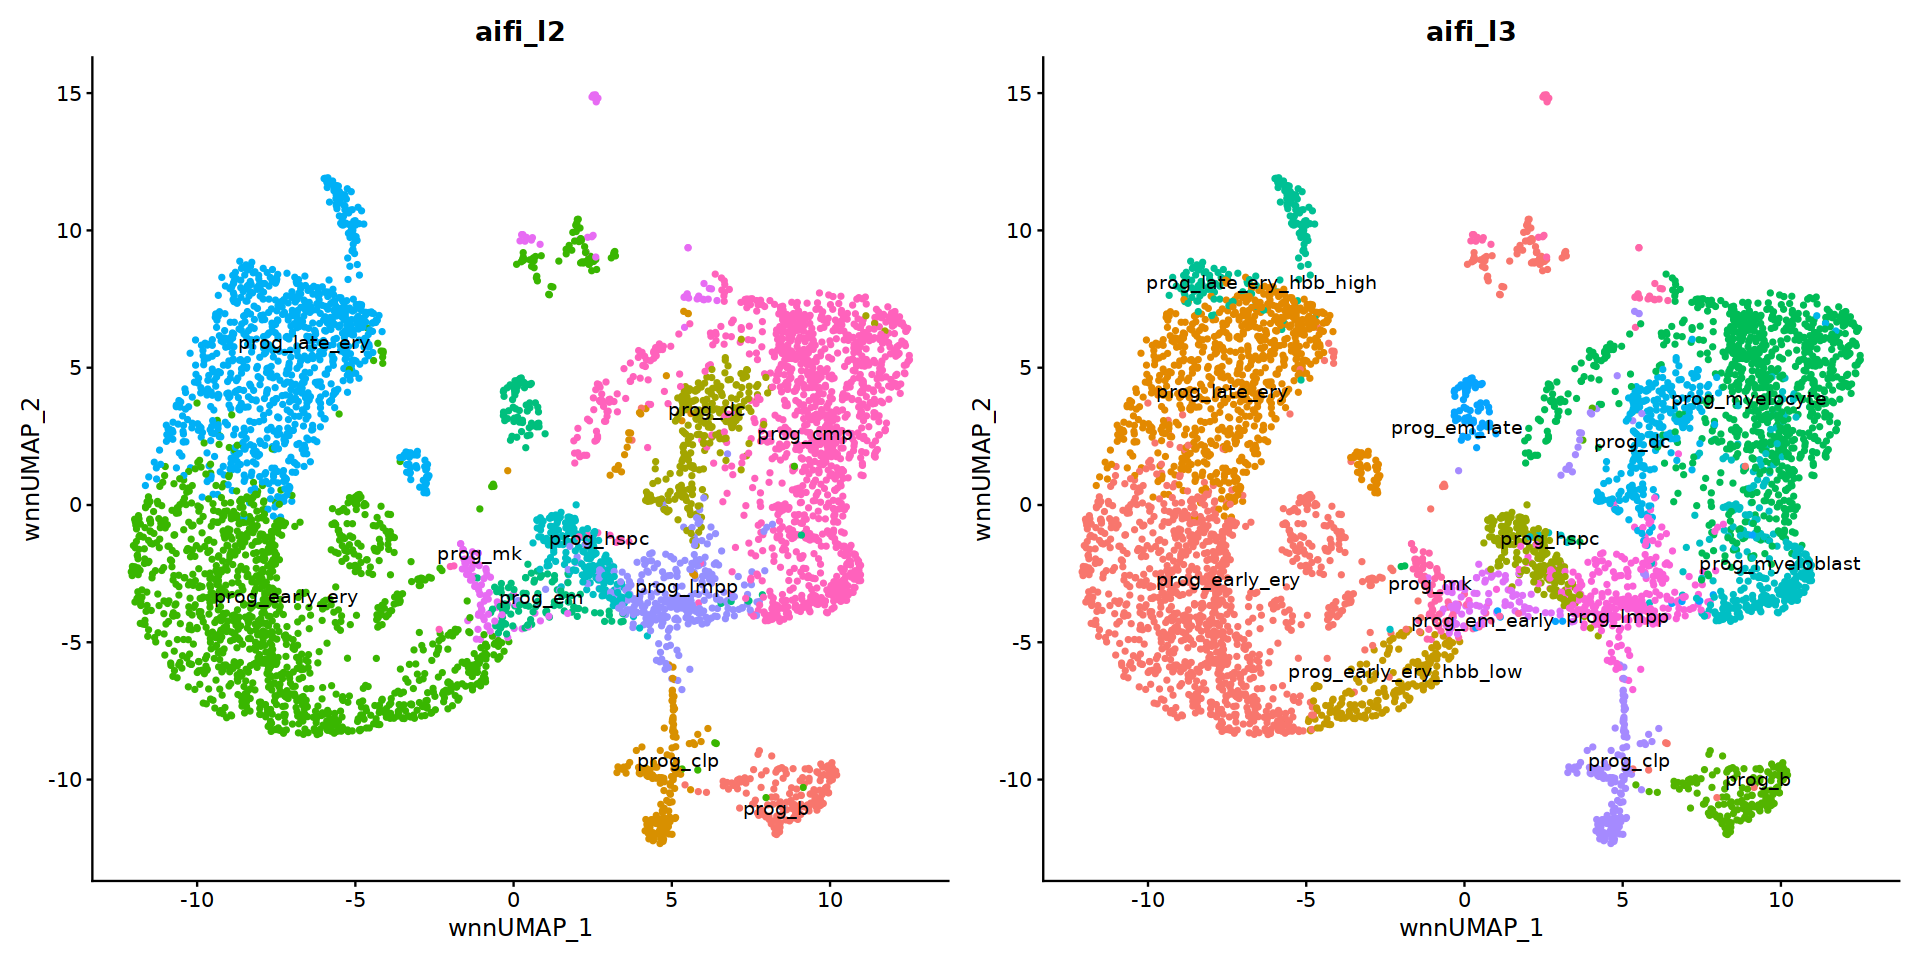

In [6]:
p1 <- gb_umap(rdata, 'aifi_l2', 'wnn.umap')
p2 <- gb_umap(rdata, 'aifi_l3', 'wnn.umap')

options(repr.plot.width = 16, repr.plot.height = 8)
p1+p2

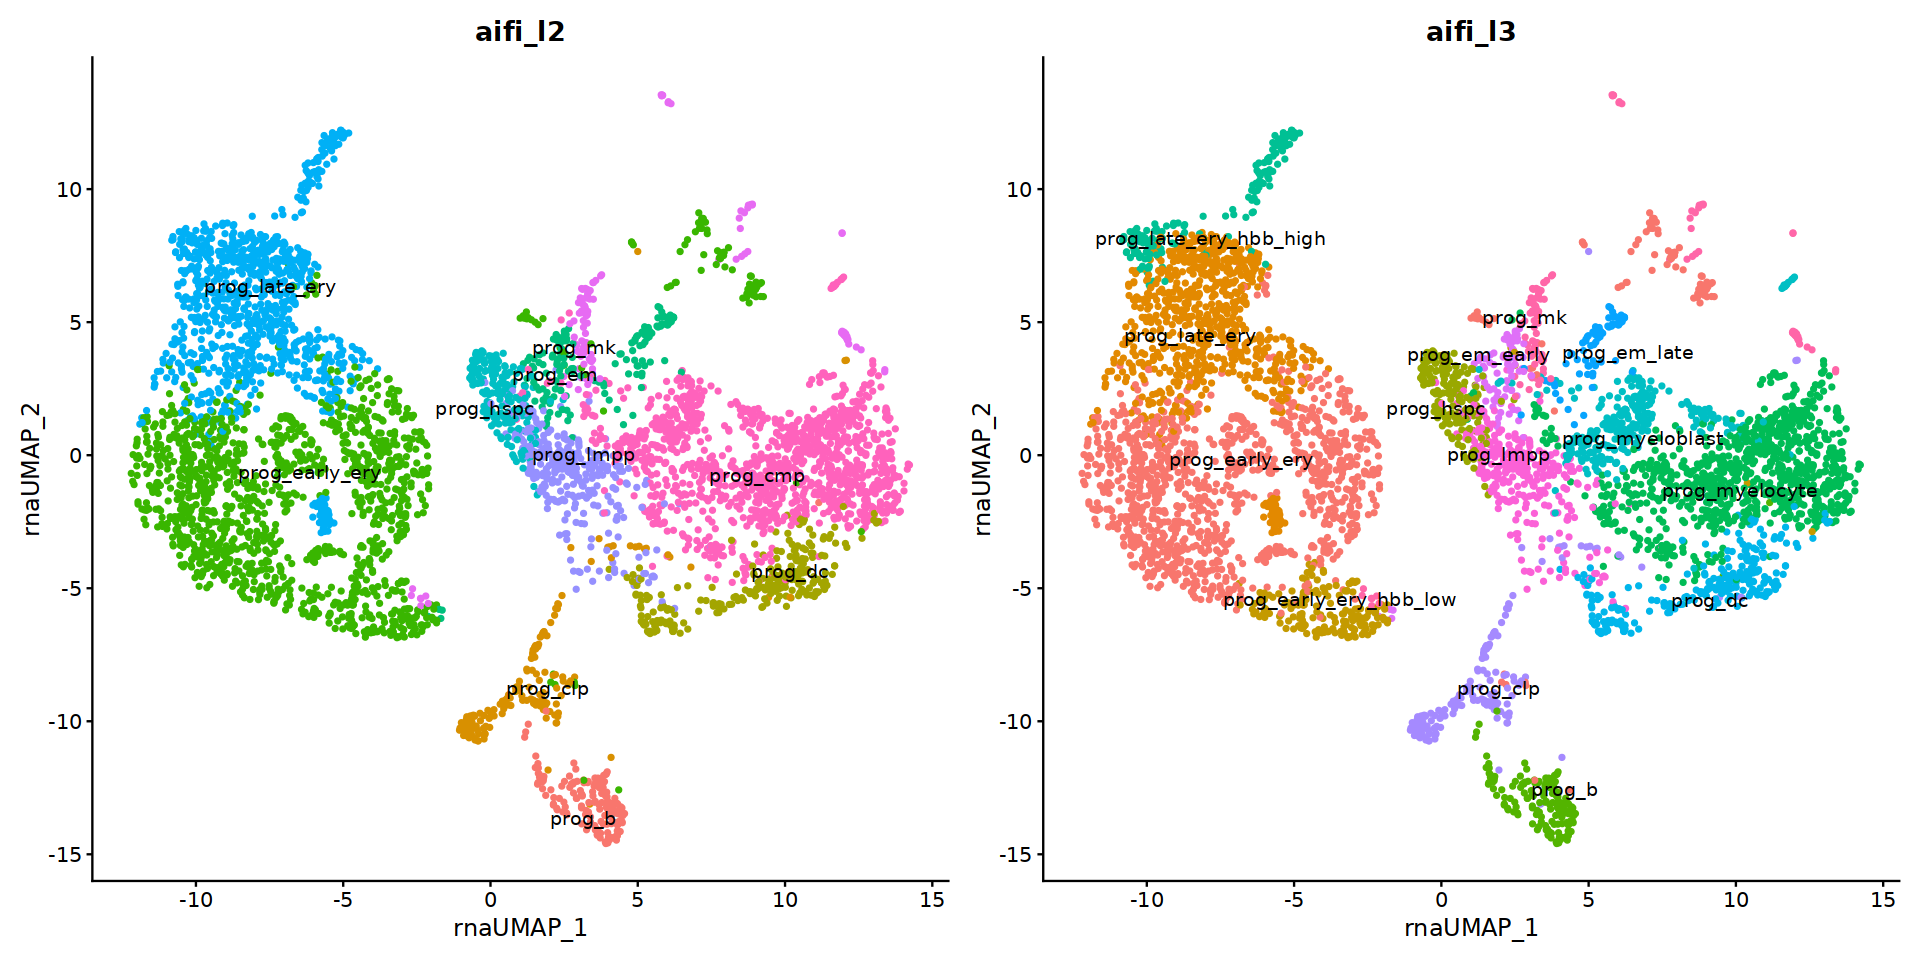

In [7]:
p1 <- gb_umap(rdata, 'aifi_l2', 'rna.umap')
p2 <- gb_umap(rdata, 'aifi_l3', 'rna.umap')

options(repr.plot.width = 16, repr.plot.height = 8)
p1+p2

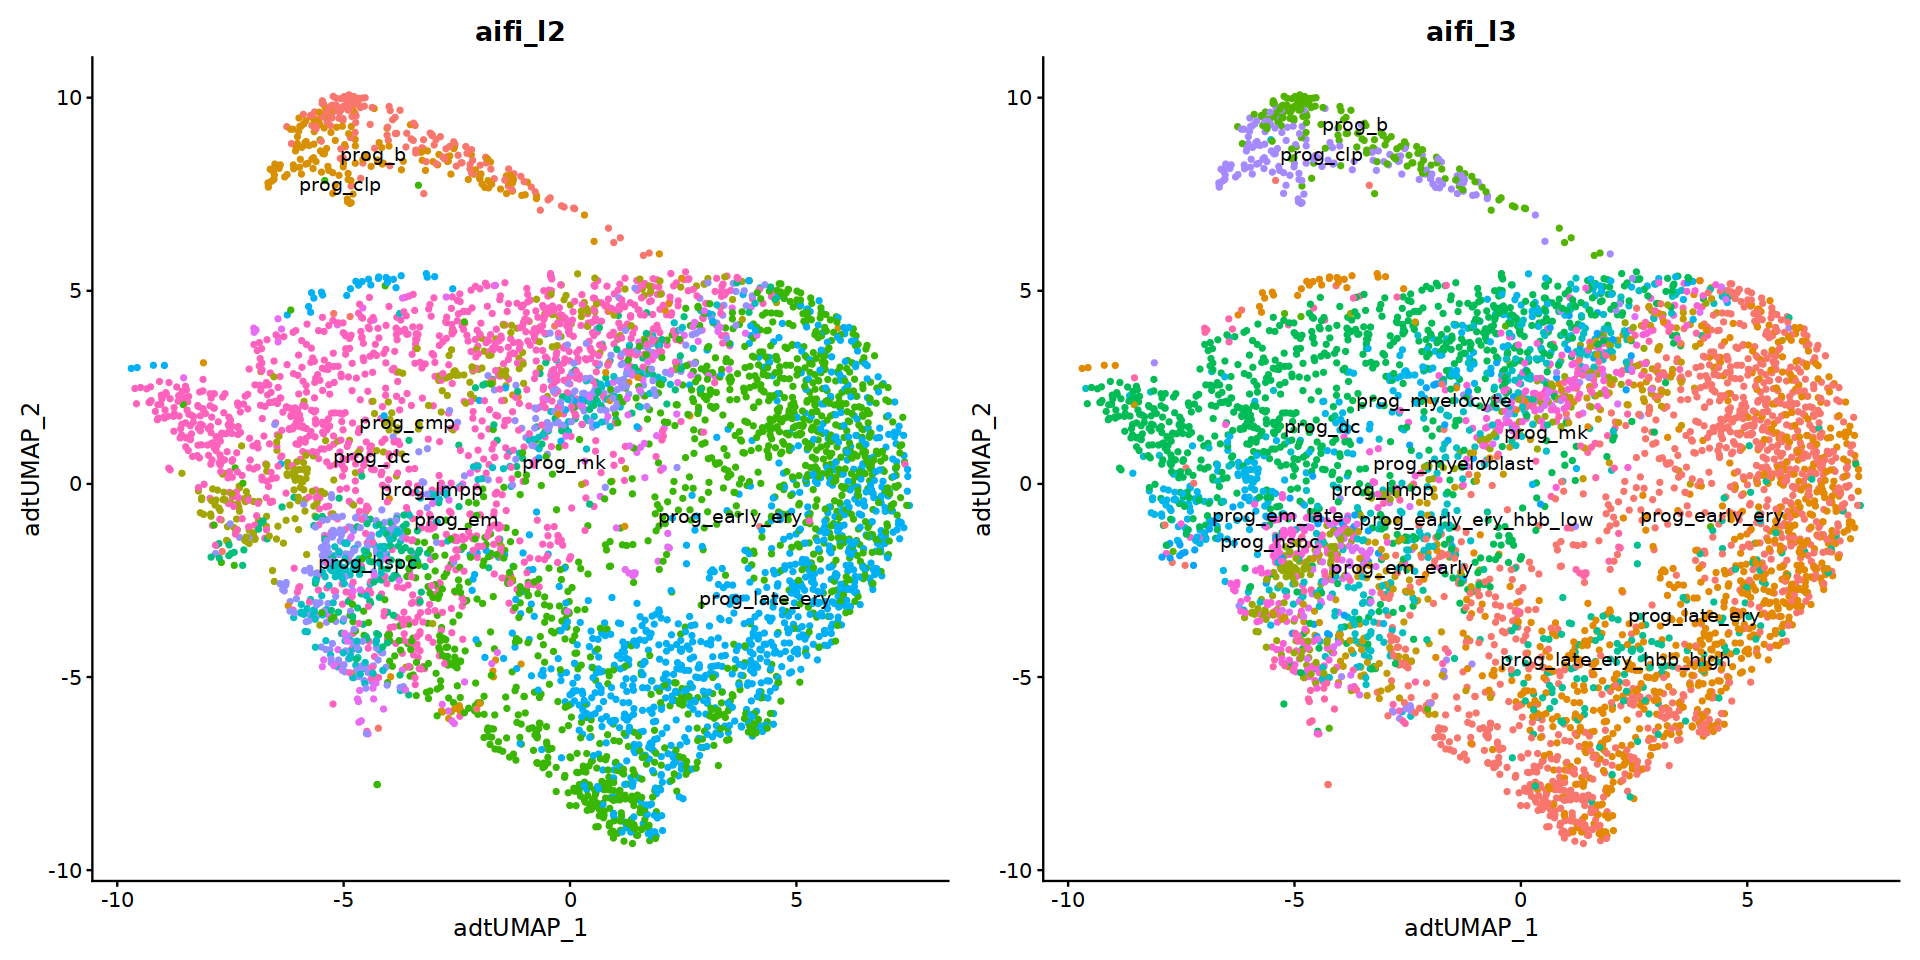

In [8]:
p1 <- gb_umap(rdata, 'aifi_l2', 'adt.umap')
p2 <- gb_umap(rdata, 'aifi_l3', 'adt.umap')

options(repr.plot.width = 16, repr.plot.height = 8)
p1+p2

In [9]:
start_time <- Sys.time()

## NMF Analysis
> In this implementation, I'll be testing the performance of NMF to see how it compares to my manual annotation (ground truth) at a Level 2 annotation as seen in the UMAP above. As a technique, NMF needs prior labeling to learn features and only needs the input to be non-negative. You can start at your raw counts to stay true to biology. For single cell analysis it's recommended to scale the data so that your features are easier to compare and interpret. 

#### Sub-quest if you're starting at assay V5: Steps to convert Assay V5 object to Assay V3 (which Singlet expects)

In [10]:
# Join disjoint layers 
rdata[["RNA"]] <- JoinLayers(rdata[["RNA"]])

# Cast to v3 Assay format
DefaultAssay(object = rdata) <- "RNA"

rdata[["RNA3"]] <- as(object = rdata[["RNA"]], Class = "Assay")
DefaultAssay(object = rdata) <- "RNA3"

Warning message:
“Key ‘rna_’ taken, using ‘rna3_’ instead”


In [11]:
# Create v3 Assay seurat object for all further steps
rdata_v3 <- CreateSeuratObject(counts = rdata[['RNA3']])

In [12]:
# Add labels from v5 dataset
## Extract metadata
rdata_meta <- rdata@meta.data

## Match sanity checks
v3_rdata_meta <- rdata_v3@meta.data[which(rownames(rdata_v3@meta.data) %in% rownames(rdata_meta)),]
table(rownames(v3_rdata_meta) %in% rownames(rdata_meta))

## Dummy column
rdata_v3[['aifi_l2']] <- 'no_name'
## Import celltype labels to working object
rdata_v3[['aifi_l2']][which(rownames(rdata_v3@meta.data) %in% rownames(v3_rdata_meta))] <- as.character(rdata_meta[['aifi_l2']])


TRUE 
5000 

### Execution
> For an input dataset with raw counts $X$, we'll normalize and run the NMF algorithm. This implementation is incredibly fast and highly parallelized; and gets us to where we need to be within seconds. Singlet automatically tests a range of $K$ values to figure out the optimal $K$, and then fits the model based on this $K$ number of components. 

In [13]:
# Normalize data and run NMF
set.seed(123)
rdata_v3 <- NormalizeData(rdata_v3) %>% singlet::RunNMF()

running with sparse optimization

REPLICATE  1 / 3 
k = 2 , rep = 1 
   test_error = 1.2642e-01 
   not overfit
   best rank in replicate = 2 

k = 3 , rep = 1 
   test_error = 1.2129e-01 
   not overfit
   best rank in replicate = 3 

k = 6 , rep = 1 
   test_error = 1.1479e-01 
   not overfit
   best rank in replicate = 6 

k = 11 , rep = 1 
   test_error = 1.1081e-01 
   not overfit
   best rank in replicate = 11 

k = 21 , rep = 1 
   test_error = 1.0803e-01 
   not overfit
   best rank in replicate = 21 

k = 39 , rep = 1 
   test_error = 1.0641e-01 
   not overfit
   best rank in replicate = 39 

k = 73 , rep = 1 
   test_error = 1.0767e-01 
   overfit (overfit_score = 4.1785e-03 )
   best rank in replicate = 39 

k = 56 , rep = 1 
   test_error = 1.0644e-01 
   overfit (overfit_score = 7.9389e-04 )
   best rank in replicate = 39 

k = 30 , rep = 1 
   test_error = 1.0692e-01 
   not overfit
   best rank in replicate = 39 

k = 47 , rep = 1 
   test_error = 1.0615e-01 
   not ove

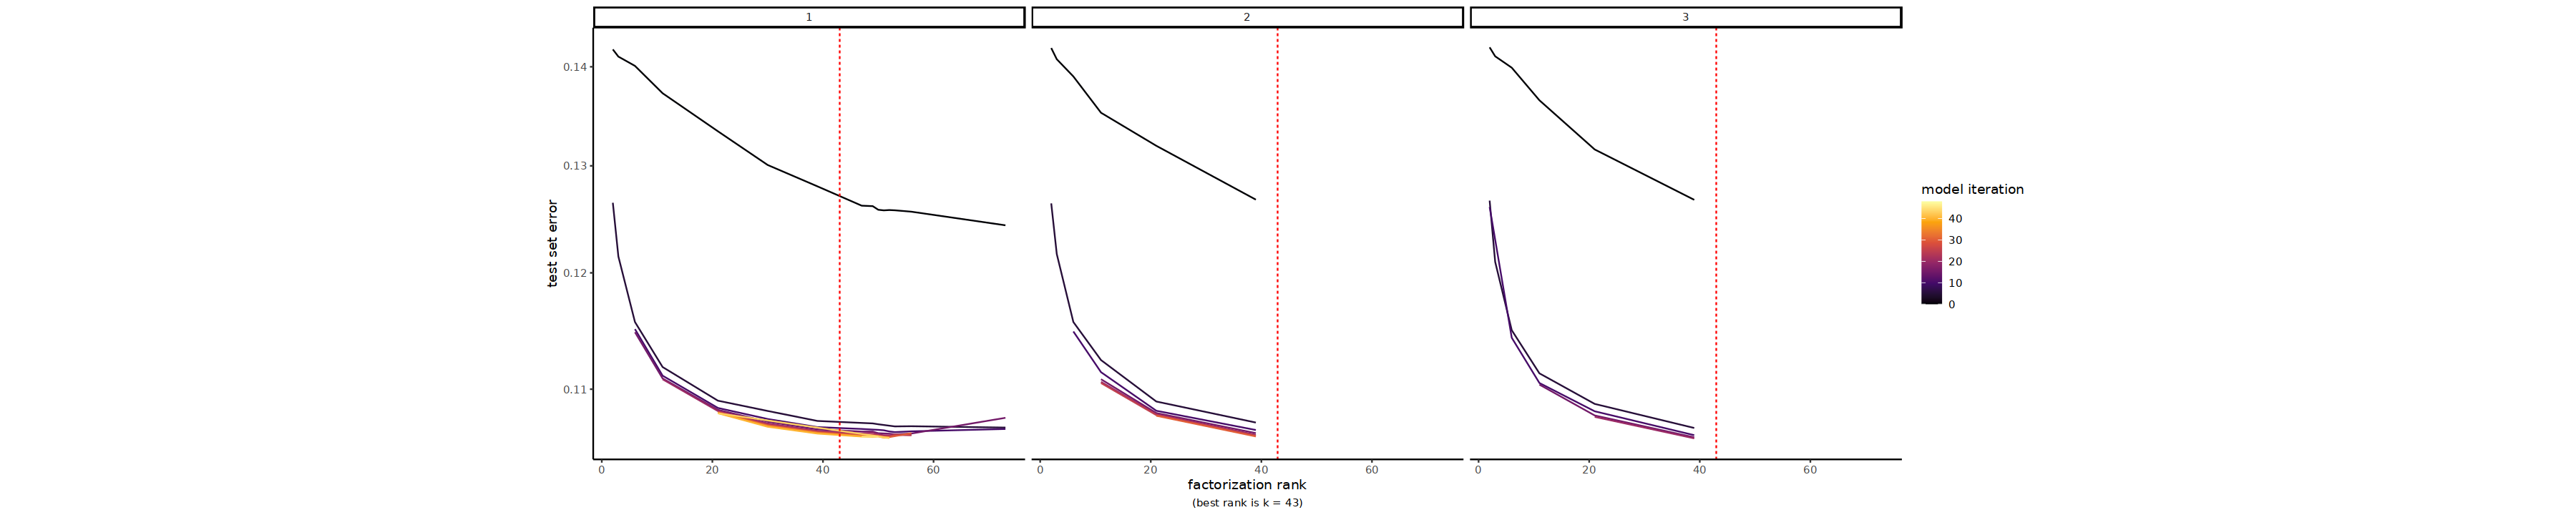

In [14]:
# Peek at model metrics for selection
options(repr.plot.width = 30, repr.plot.height = 6)
RankPlot(rdata_v3)

> Here, we can see that at K = 43 the following components explain our existing cell types as follows:

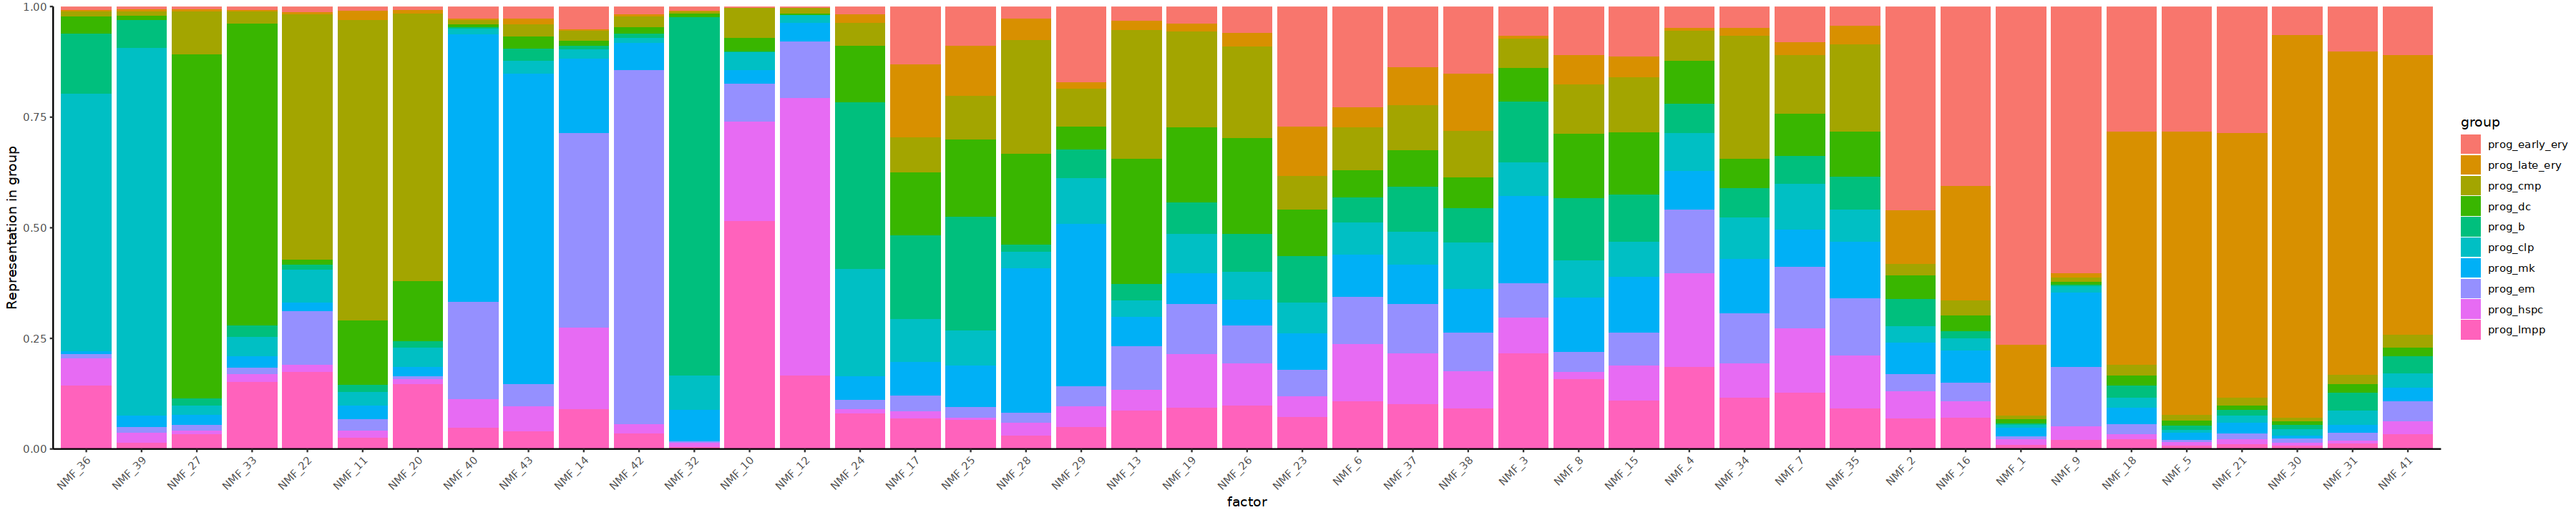

In [15]:
# Check cell types vs weights
options(repr.plot.width = 30, repr.plot.height = 6)
MetadataPlot(rdata_v3, 'aifi_l2', reduction = "nmf")

> You can also take a look at what genes inform each of the components by plotting gene weights for genes based on components

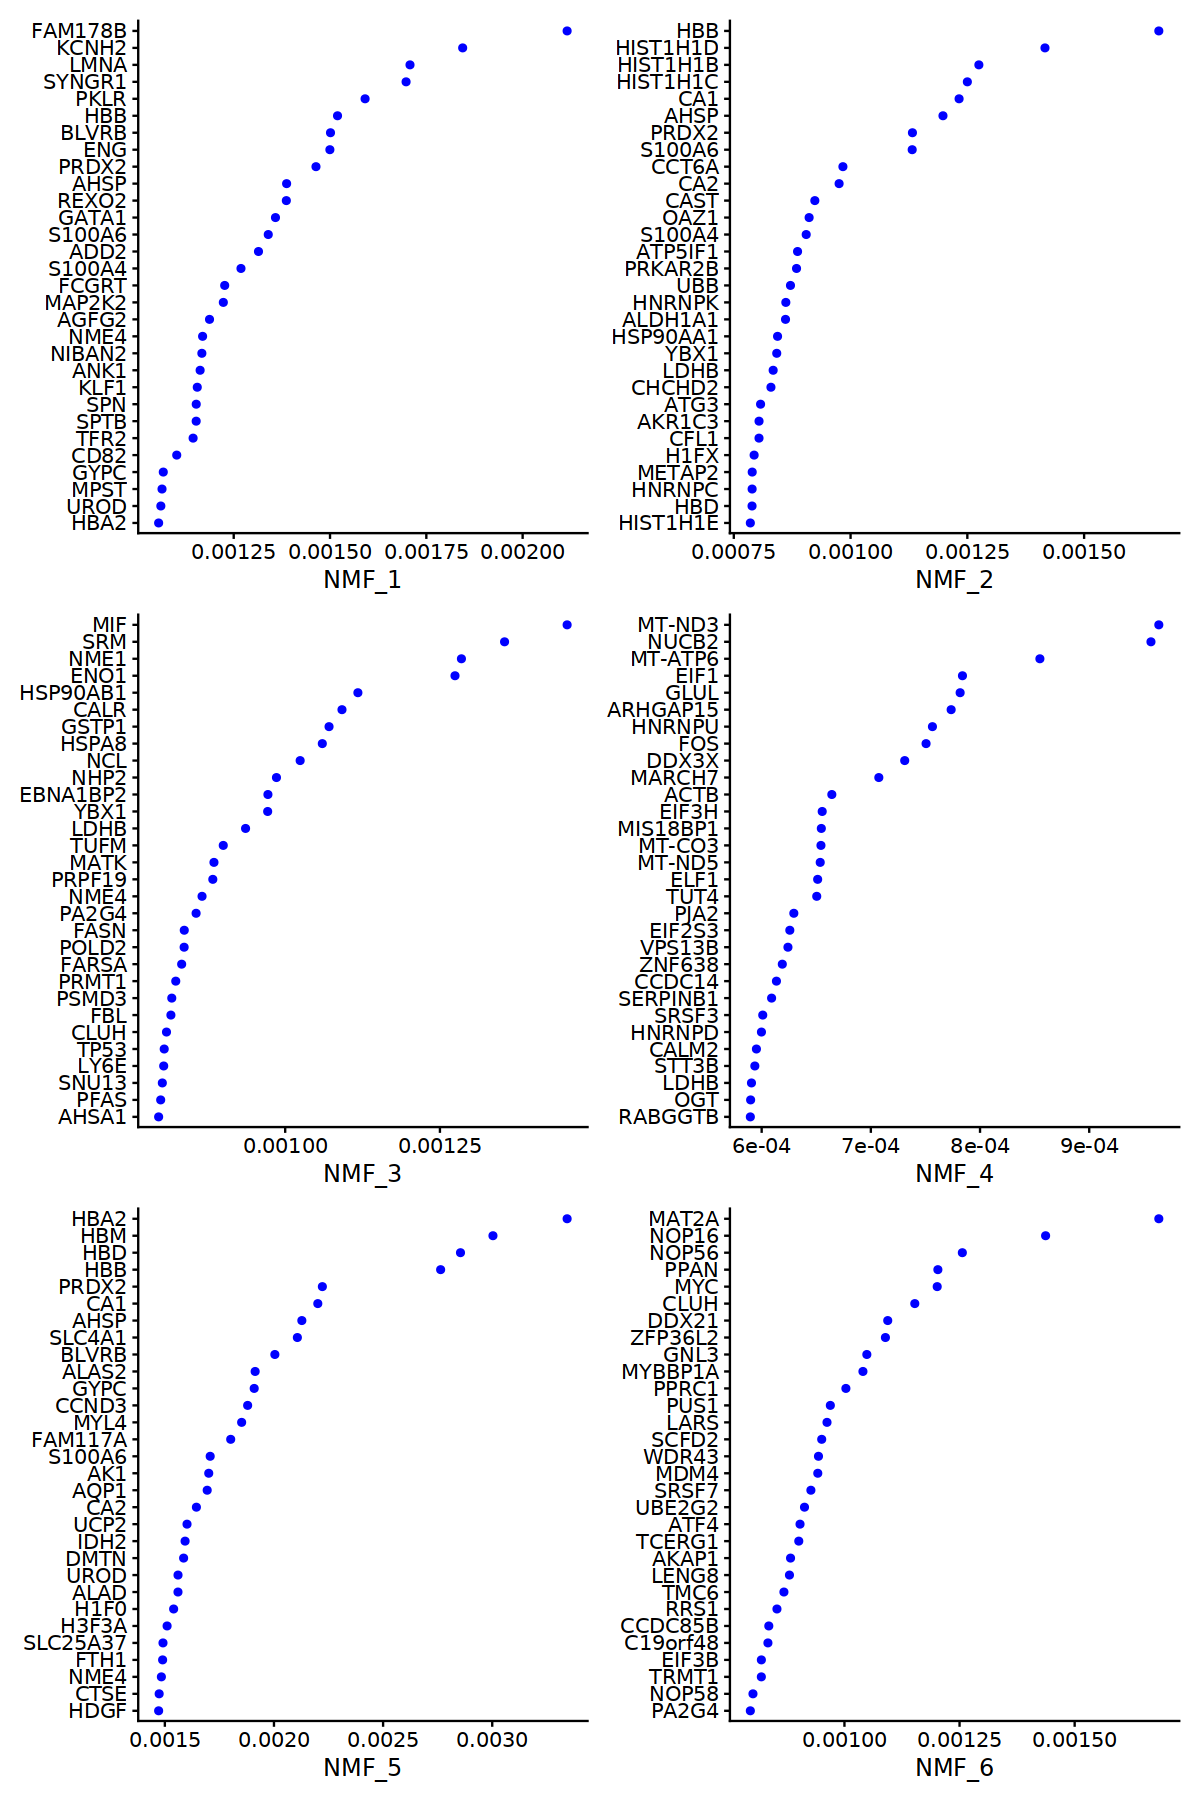

In [16]:
# Check gene distribution dimensions
options(repr.plot.width = 10, repr.plot.height = 15)
VizDimLoadings(rdata_v3, dims = 1:6, reduction = "nmf")

> For confirmation of components linking to biological relevance, we can run fgsea that comes wrapped in Singlet. The weights in the NMF “w” matrix are used as rankings for terms in the enrichment analysis.

In [17]:
rdata_v3 <- RunGSEA(rdata_v3, category = "C7", verbose = FALSE)

running GSEA on 43 factors...
  |======================================================================| 100%


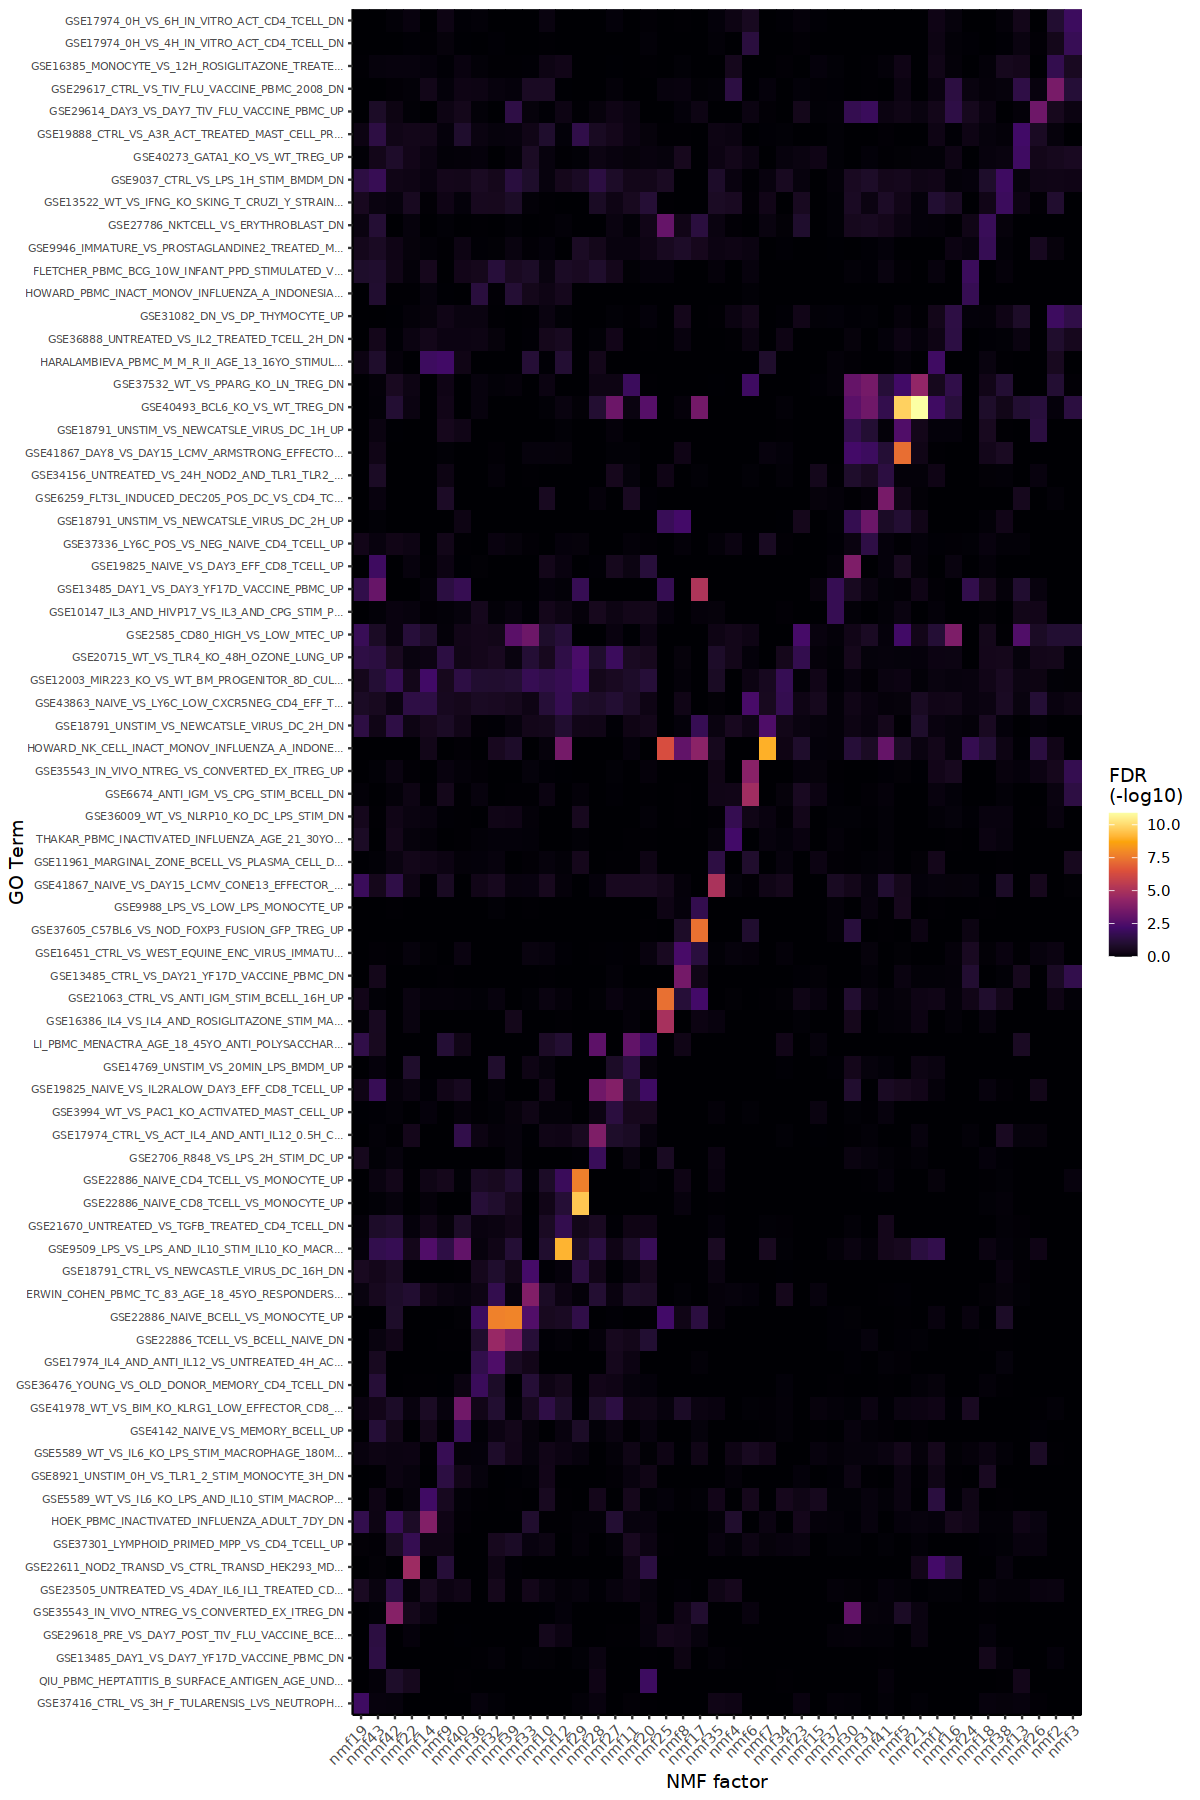

In [18]:
GSEAHeatmap(rdata_v3, reduction = "nmf", max.terms.per.factor = 2)

In [19]:
# Create UMAP, louvain clusters based on nmf loadings
rdata_v3 <- FindNeighbors(rdata_v3, dims = 1:ncol(rdata_v3@reductions$nmf), reduction = "nmf") %>%
  FindClusters(resolution = 0.5, verbose = FALSE) %>%
  RunUMAP(reduction = "nmf", dims = 1:ncol(rdata_v3@reductions$nmf), verbose = FALSE)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



In [20]:
# Save cluster numbers with an alt metadata column 
rdata_v3@meta.data$louvain_numbers <- rdata_v3@meta.data$seurat_clusters

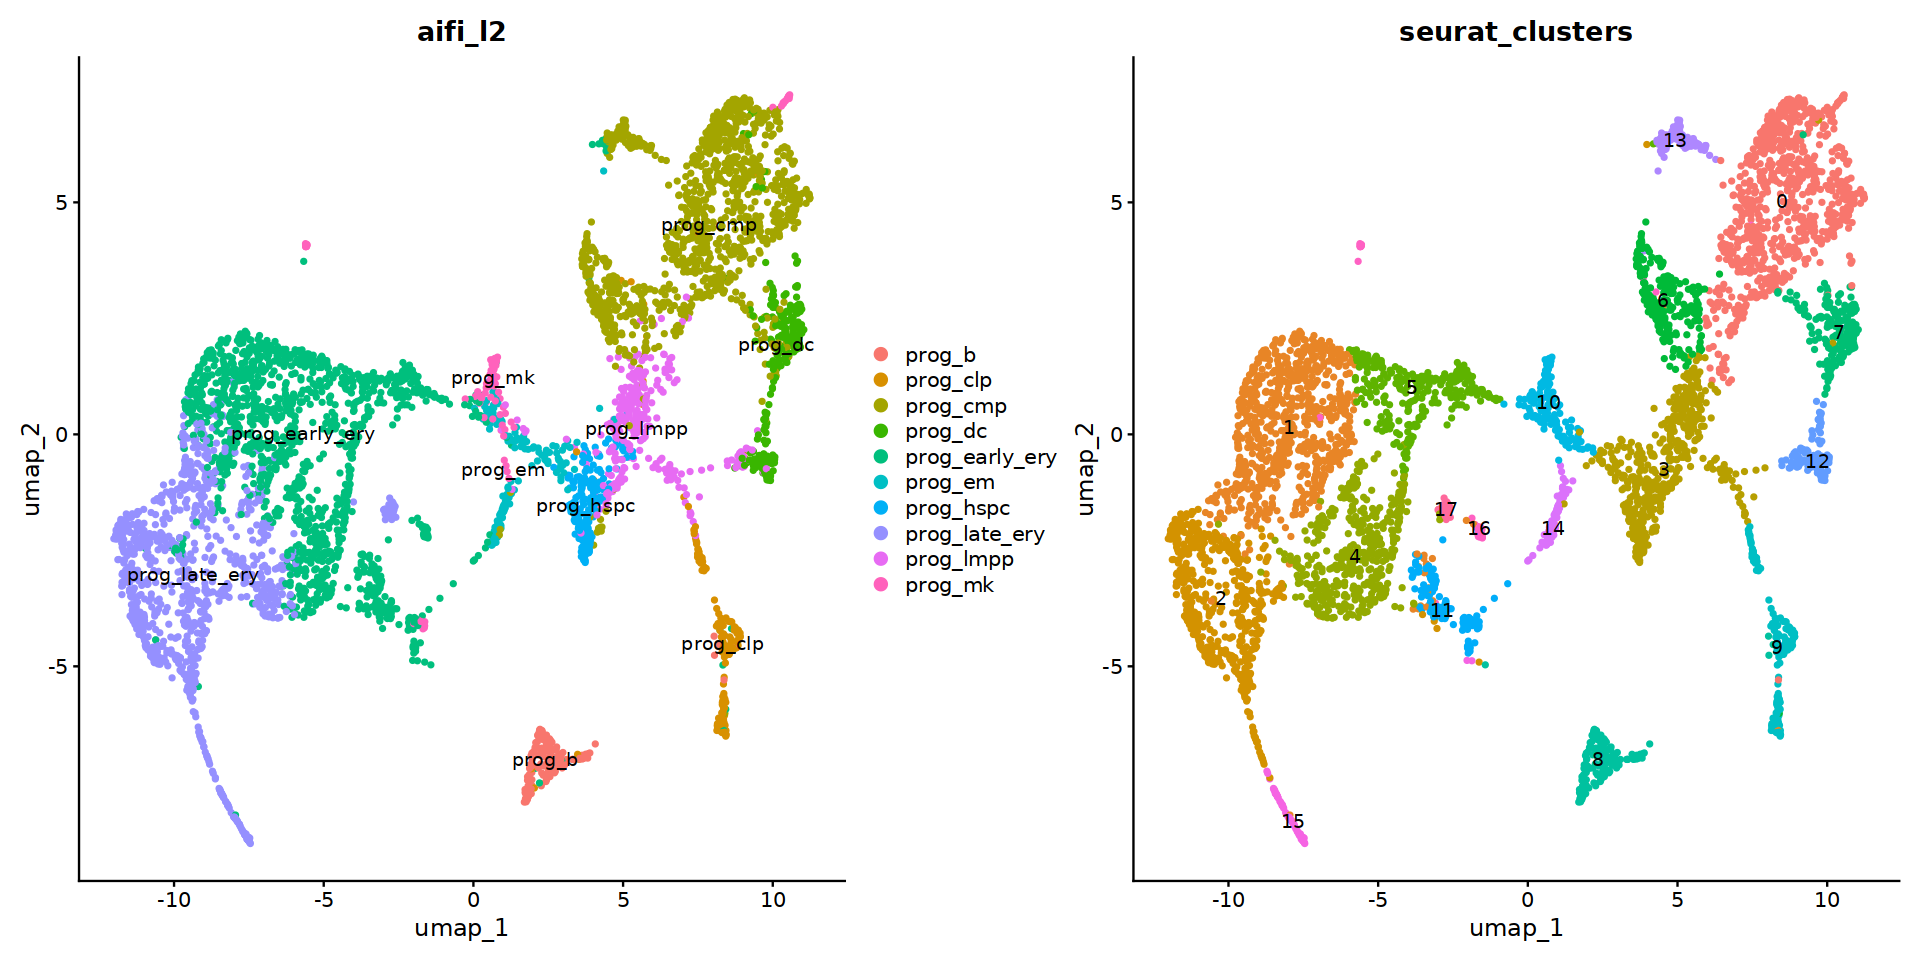

In [21]:
# Visualize UMAP
options(repr.plot.width = 16, repr.plot.height = 8)
DimPlot(rdata_v3, 
        reduction = "umap", 
        group.by = c("aifi_l2", "seurat_clusters"), label = TRUE, 
        pt.size = 1) + NoLegend()

### Automatically label nearest NMF-louvain clusters based on their closest match

> We can see how much of a cluster matches an existing label to refine labels based on the louvain clustering on the NMF nearest neighbor graph. This is also where you would step back to manually annotate or analyze DEGs on your binary label assignments. The assumption is that these clusters are better representative of true biology because the input is the complete dataset and not the first few principal components. 

In [22]:
# adjust cell type labels 
df <- data.frame(
  "nmf_clusters" = rdata_v3@meta.data$seurat_clusters,
  "pca_clusters" = rdata_v3@meta.data$aifi_l2)

## remove NA values
df <- df[!is.na(df$pca_clusters), ]

## compute frequency 
df <- df %>% 
  group_by(nmf_clusters) %>% 
  count(pca_clusters) %>% 
  mutate(freq = n / sum(n))

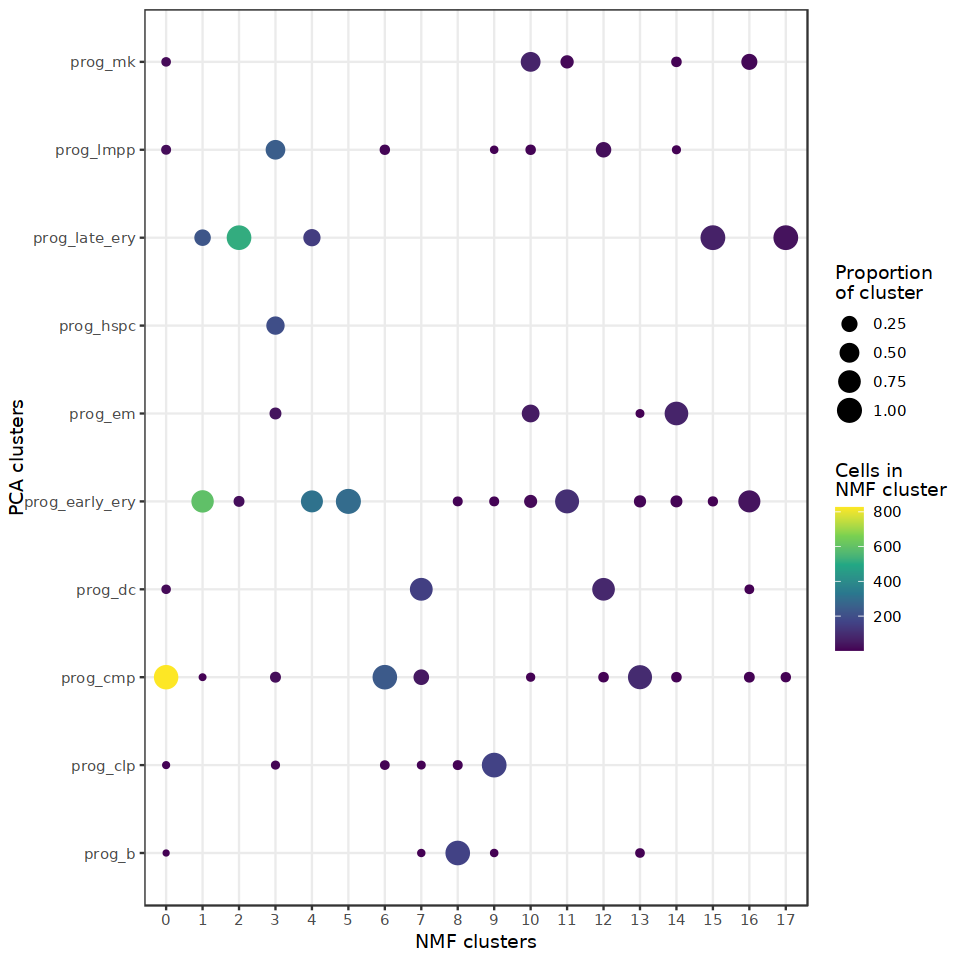

In [23]:
## Plot dotplot matching nmf to seurat clusters
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(df, aes(nmf_clusters, pca_clusters, size = freq, color = n)) + 
  geom_point() + 
  theme_bw() + 
  labs(x = "NMF clusters", 
       y = "PCA clusters", 
       size = "Proportion\nof cluster", 
       color = "Cells in\nNMF cluster") + 
  scale_color_viridis_c(option = "D")

In [24]:
## Add cluster names based on pca values
cluster_names <- df %>% 
  slice(which.max(n)) %>% 
  pull(pca_clusters)

## Change cluster names based on NMF computing
levels(rdata_v3@meta.data$seurat_clusters) <- make.unique(as.vector(cluster_names))

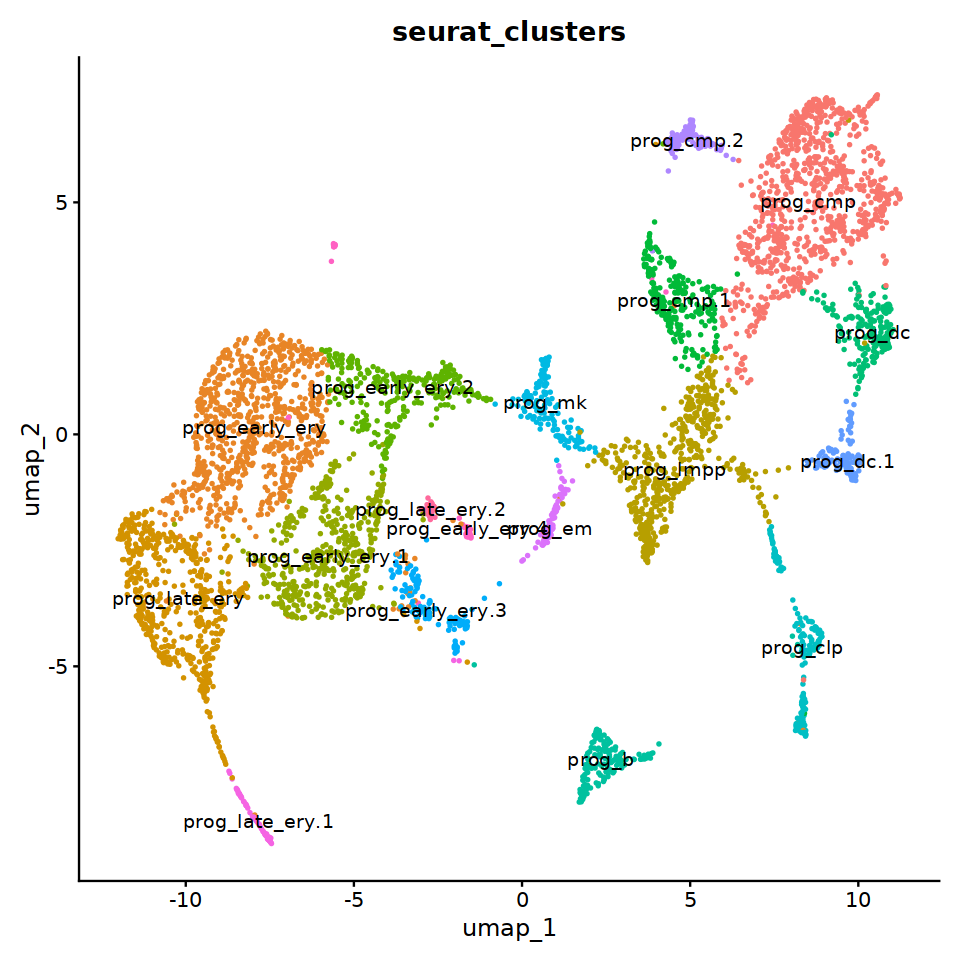

In [25]:
## Visualize label swapped clusters
options(repr.plot.width = 8, repr.plot.height = 8)
DimPlot(rdata_v3, 
        reduction = "umap", 
        label = TRUE, 
        group.by = "seurat_clusters", 
        pt.size = 0.5) + NoLegend()

> ...Annnnd we can visualize what these components look like next to our labeled data to see if they inform meaningful parts. Some intuition here (per my understanding) is that each component shows us what a set of gene batteries look like. Certain batteries will inform us for features of classification (cell types), some will tell us meaningful biology (pathways, reactions states) and some may just tell us about technical effects (artifacts, donor effects, batching). 

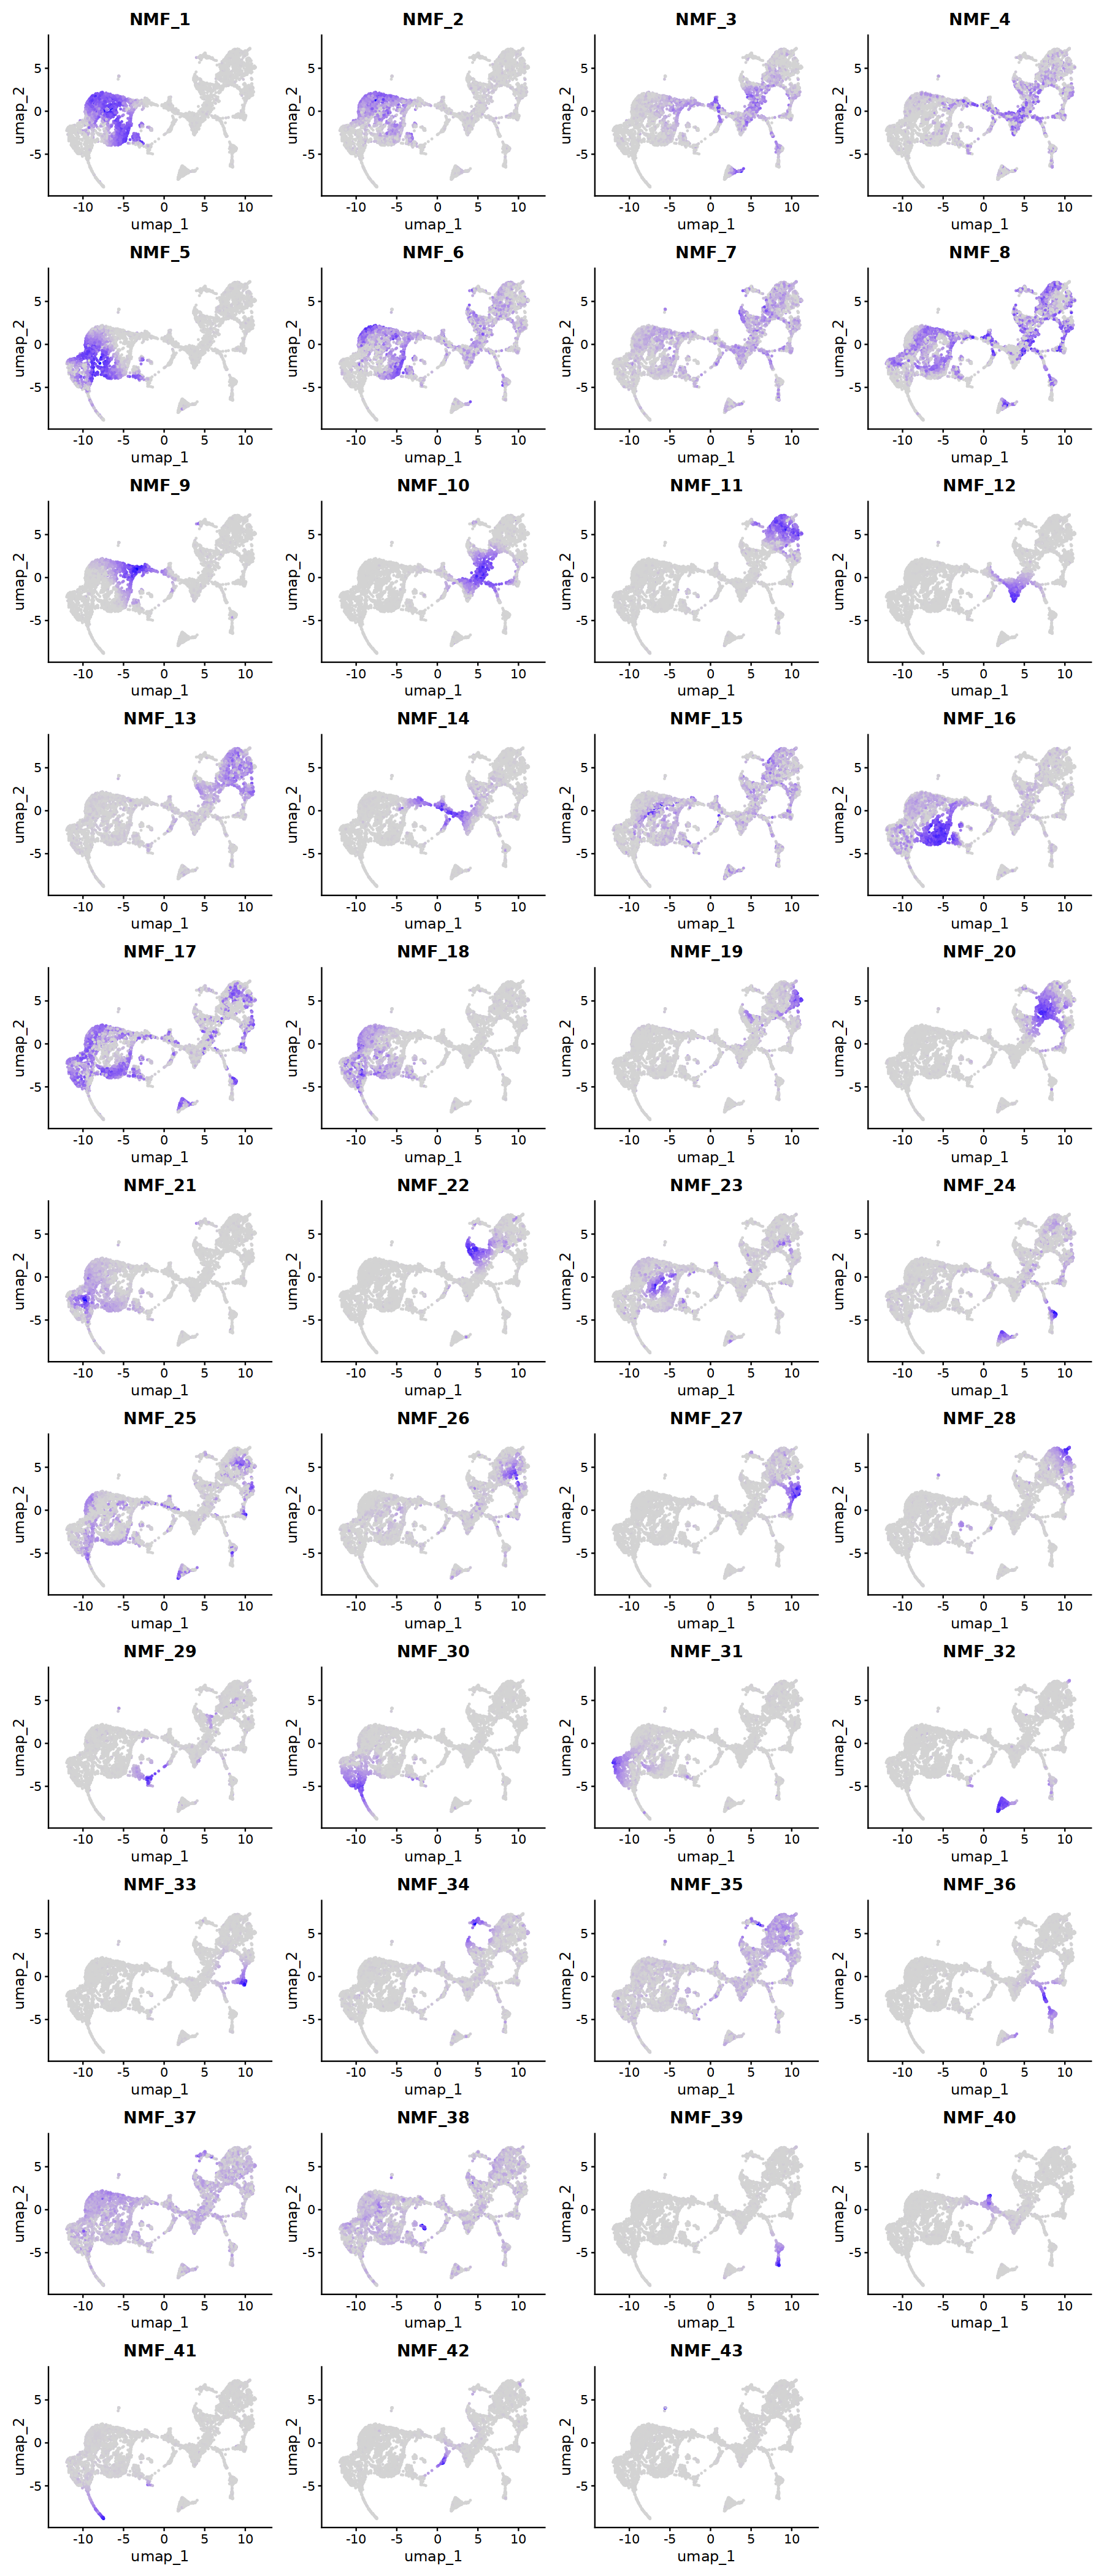

In [26]:
options(repr.plot.width = 15, repr.plot.height = 35)
FeaturePlot(rdata_v3, features = paste0("NMF_", 1:43)) & NoLegend()

In [27]:
rdata_v3

An object of class Seurat 
18082 features across 5000 samples within 1 assay 
Active assay: RNA (18082 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: nmf, umap

### Crossembedding: Adding NMF signals to multimodal data 

> If you happen to have multimodal data, you can use the NMF loading as an input to generate a weighted nearest neighbor graph. Here, we're integrating NMF x APCA of CITE_seq ADTs but you could also run NMF on the ADT data and make a WSNN using RNA_NMF x ADT_NMF to have the feature space limited to one dimensionality reduction technique. I'm just going to show you how it's done and you can adjust it based on your use cases. 

In [28]:
rdata@reductions$nmf <- rdata_v3@reductions$nmf ## Add loadings from V3 object to V5
rdata

An object of class Seurat 
36314 features across 5000 samples within 3 assays 
Active assay: RNA3 (18082 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, ADT
 8 dimensional reductions calculated: pca, apca, wnn.umap, rna.umap, adt.umap, harmony_rna, harmony_adt, nmf

> Use all NMF components as they all contain valuable information. We're not assessing variablity so we need all subparts to make up the whole. 

In [29]:
rdata <- FindMultiModalNeighbors(
  rdata, reduction.list = list("nmf", "apca"), 
  dims.list = list(1:ncol(rdata@reductions$nmf), 1:18), modality.weight.name = "RNA.weight"
)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Warning message in FindMultiModalNeighbors(rdata, reduction.list = list("nmf", "apca"), :
“The number of provided modality.weight.name is not equal to the number of modalities. RNA.weight ADT.weight are used to store the modality weights”
Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



In [30]:
rdata <- RunUMAP(rdata, nn.name = "weighted.nn", reduction.name = "wnn.nmf.umap", reduction.key = "wnnUMAP_")
rdata <- FindClusters(rdata, graph.name = "wsnn", algorithm = 3, resolution = 0.5, verbose = FALSE)

21:28:13 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

21:28:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

21:28:16 Initializing from normalized Laplacian + noise (using RSpectra)

21:28:16 Commencing optimization for 500 epochs, with 143546 positive edges

21:28:23 Optimization finished

Warning message:
“Key ‘wnnUMAP_’ taken, using ‘wnnnmfumap_’ instead”


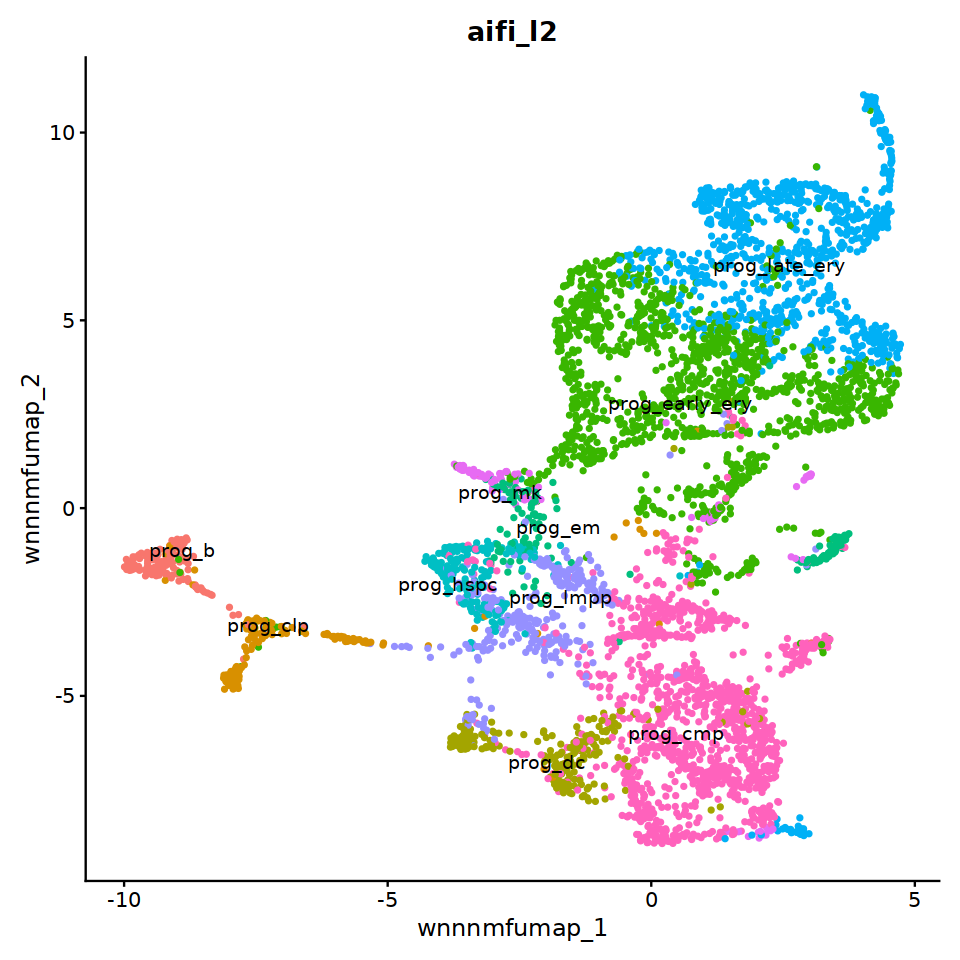

In [31]:
options(repr.plot.width = 8, repr.plot.height = 8)
DimPlot(rdata, reduction = 'wnn.nmf.umap', group.by='aifi_l2',
        label = TRUE, repel = TRUE, shuffle=TRUE, raster=FALSE,
        label.size = 4, pt.size=1) + NoLegend()

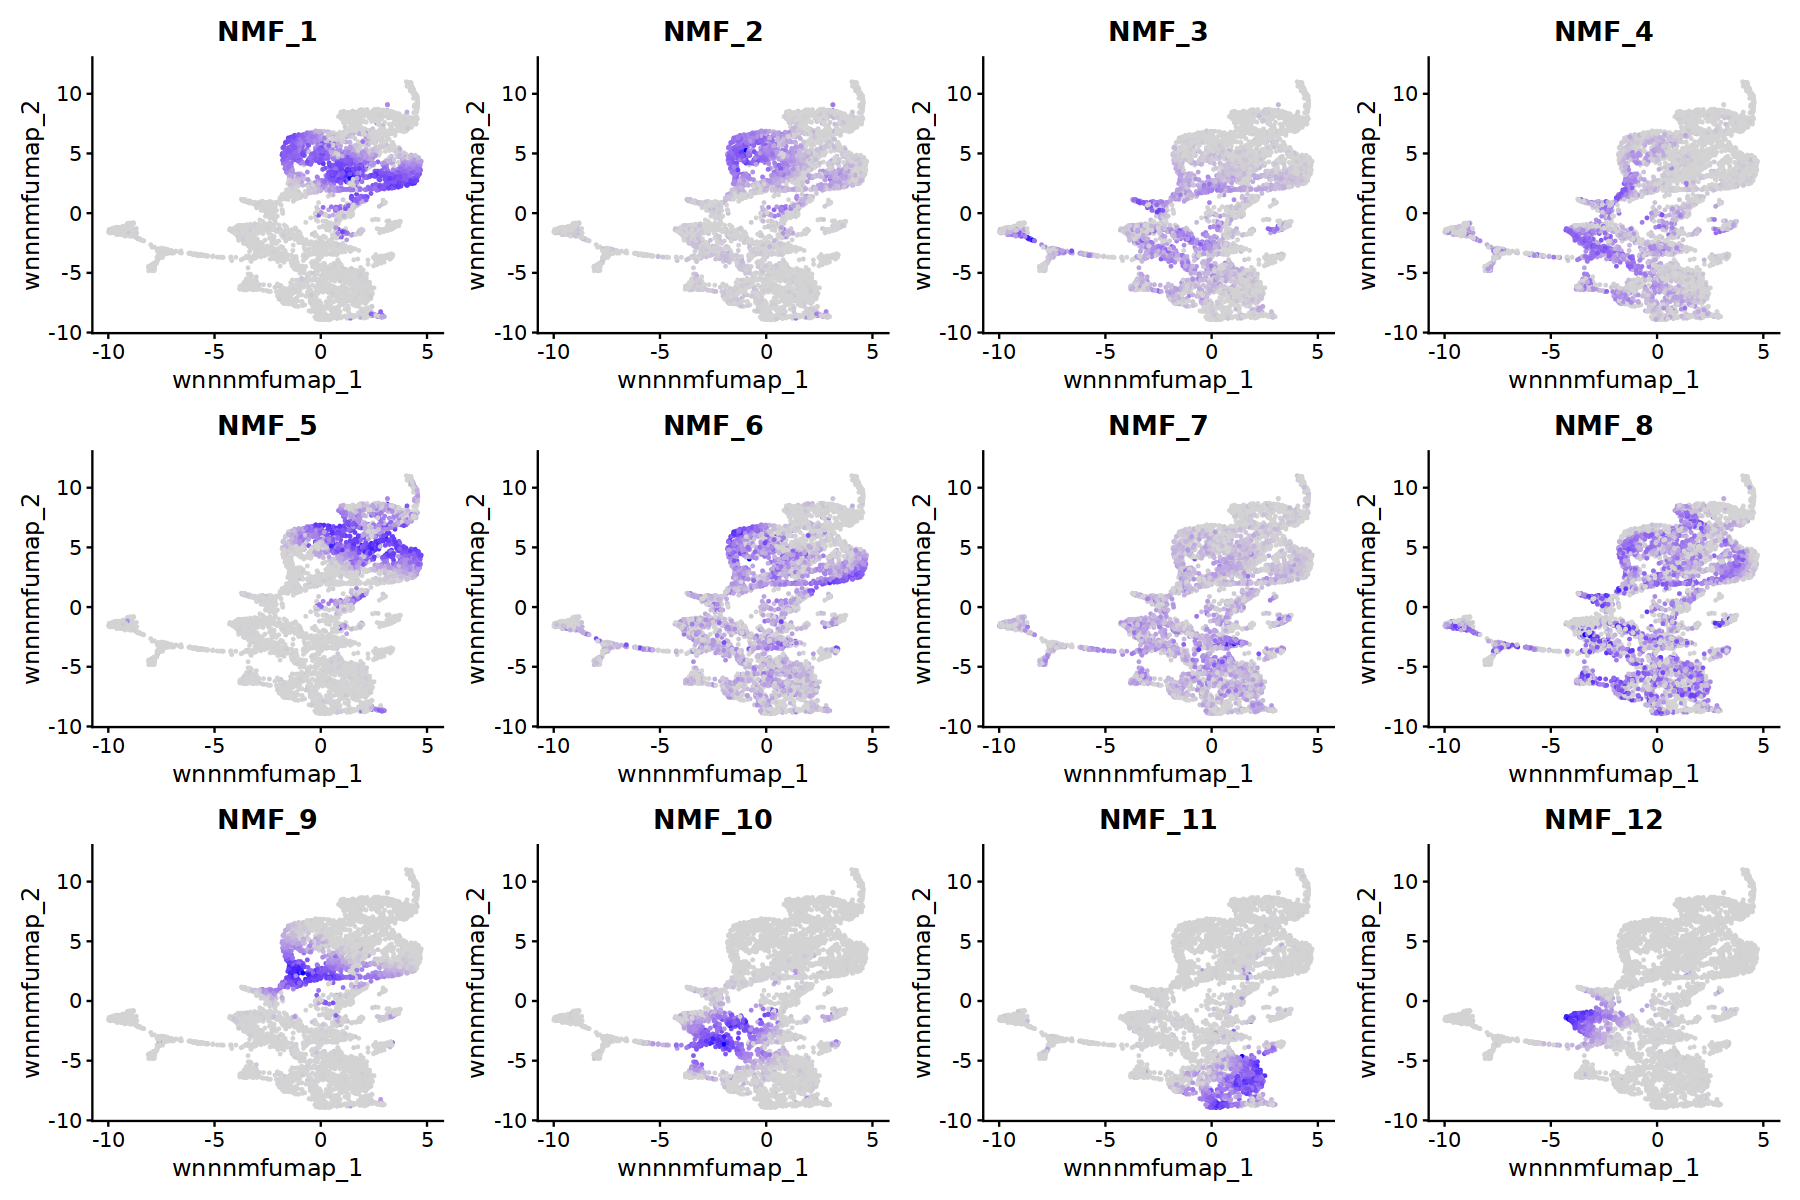

In [36]:
options(repr.plot.width = 15, repr.plot.height = 10)
FeaturePlot(rdata, features = paste0("NMF_", 1:12)) & NoLegend()

In [33]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] singlet_0.99.6      RcppEigen_0.3.4.0.0 RcppML_0.5.6       
 [4] Seurat_5.0.3        SeuratObject_5.0.1  sp_2.1-3           
 [7] patchwork_1.2.0     ggplot2_3.5.0       stringr_1.5.1      
[10] dplyr_1.1.4        

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3          jsonlite_1.8.8 

> #### TLDR; NMF is PCA but better & now that we have a fast implementation theres no reason why we shouldn't add it to our analysis archive.
### Happy Coding!

## Resources and references: 
1. Lee and Seung's original NMF paper from 1999. It's sooooo very easy to read and understand. https://www.nature.com/articles/44565
2. Classnotes from MCB112 at Harvard FAS. This is where I learnt how to NMF and use it for biological data analysis. Bonus, look through the section, pset and answer tabs for more insights and intution on use cases. http://mcb112.org/w10/w10-lecture.html
3. CoGAPS Implementation of Bayesian NMF. https://www.nature.com/articles/s41596-023-00892-x
4. Paper behind this NMF implementation. https://www.biorxiv.org/content/10.1101/2021.09.01.458620v1
5. Dylan K's original cNMF paper. https://elifesciences.org/articles/43803
6. Very helpful video explaining the use of NMF for single cell data. https://youtu.be/9f4Rwt0yqr4?feature=shared